In [ ]:
# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import FISTA, HybridGLSQR, GLSQR
from cil.optimisation.utilities.HybridUpdateReg import UpdateRegDiscrep, UpdateRegGCV, UpdateRegLcurve, UpdateRegReginska, UpdateRegUPRE
from cil.optimisation.operators import WaveletOperator
from cil.optimisation.functions import L1Norm,  LeastSquares, L1Sparsity

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# CIL data structures and utilities
from cil.utilities.display import show2D

# Third-party imports
import numpy as np    

## Load ISIS cylinder data

Set the desired exposure time and number of angles, then read the data.

Next we get the data geometries and define the projection operator. We also bin the data in half in all dimensions to speed-up the computations.

### Exposure time and number of angles options

| Parameter | Dataset 1 | Dataset 2 | Dataset 3 | Dataset 4 | Dataset 5 | Dataset 6 | Dataset 7 |
| :--- | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| **Exposure Time (s)** | 7.5 | 15 | 30 | 60 | 60 | 60 | 60 |
| **Number of Angles** | 840 | 420 | 210 | 105 | 210 | 240 | 840 |

In [ ]:
from data_loader import load_and_process_cylinder


filename = "/home/dnz75396/preprocessed_data"
data, ig,ag = load_and_process_cylinder(dataset_no=5,reduce_size=True, 
                                        filename=filename)
A = ProjectionOperator(ig, ag, device = "gpu")

# Color bar for all images
cbar = (0.0,2.0)

New geometry:  3D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1., 0.]
	Rotation axis position: [0.0412434, 0.       , 0.       ]
	Rotation axis direction: [0.00258149, 0.        , 0.99999667]
	Detector position: [0., 0., 0.]
	Detector direction x: [1., 0., 0.]
	Detector direction y: [0., 0., 1.]
Panel configuration:
	Number of pixels: [310 775]
	Pixel size: [0.0096 0.0096]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 210
	Angles 0-9 in degrees: [ 0.   ,  1.716,  3.432,  5.148,  6.864,  8.58 , 10.296, 12.012, 13.728,
 15.444]
	Angles 200-209 in degrees: [343.2  , 344.916, 346.632, 348.348, 350.064, 351.78 , 353.496, 355.212,
 356.928, 358.644]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance
Shape out:  (775, 210, 310)
New geometry shape:  (775, 210, 310)
Number of channels: 1
channel_spacing: 1.0
voxel_num : x310,y310,z775
voxel_

# Choosing a good regularization parameter

It is difficult to predict a good regularization parameter $\alpha$ a priori. Let's investigate the reconstruction for a couple of different parameters with FISTA.

In [ ]:
# Try different regularization parameters and observe reconstructions
alphavec = [0, 1e-2, 0.05, 1e-1, 0.5, 1]
maxit = 50

wname = 'db2'
level = 4

W = WaveletOperator(ig, level=level, wname=wname)

F = LeastSquares(A, data)

initial = x0 = ig.allocate(0.0)


fistalist = []
for alpha in alphavec:
    G = alpha * L1Sparsity(W)
    fista = FISTA(f = F, 
                g = G, 
                initial = initial,
                update_objective_interval = 10)
    fista.run(iterations=maxit, verbose=True)
    fistalist.append(fista.solution)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
# Define the list of solutions and titles once

solutions = fistalist


titles = [
    f'alpha = {alphavec[0]:.3f}',
    f'alpha = {alphavec[1]:.3f}', 
    f'alpha = {alphavec[2]:.3f}', 
    f'alpha = {alphavec[3]:.3f}',
    f'alpha = {alphavec[4]:.3f}',
    f'alpha = {alphavec[5]:.3f}',
]

# Mapping for the dropdown
rule_options = {
    'All Rules': None,
    titles[0]: 0,
    titles[1]: 1,
    titles[2]: 2,
    titles[3]: 3,
    titles[4]: 4,
    titles[5]: 5,
}

def update_display(vslice, rule_name,norm_name='L1'):
    # Determine which solutions to show
    idx = rule_options[rule_name]
    
    if idx is None:
        # Show all
        current_solutions = solutions
        current_titles = titles
        cols = 3
    else:
        # Show only the selected one
        current_solutions = [solutions[idx]]
        current_titles = [titles[idx]]
        cols = 1

    # Render using show2D
    fig = show2D(
        current_solutions,
        cmap='inferno', 
        slice_list=('vertical', vslice), 
        num_cols=cols,
        fix_range=cbar,
        title=current_titles
    )
    
    # Add the overall title (suptitle)
    # We use plt.gcf() to ensure we grab the figure show2D just created
    fig = plt.gcf()
    fig.suptitle(f"Standard Tikhonov Analysis {norm_name}\nRule: {rule_name} | Vertical Slice: {vslice}", 
                 fontsize=14, fontweight='bold', y=1.05)
    
    # Adjust layout so the suptitle doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Determine dimensions
max_vslice = solutions[0].shape[0] - 1

# Create the interactive dashboard
interact(
    update_display, 
    vslice=IntSlider(min=0, max=max_vslice, step=1, value=107, description='Slice:'),
    rule_name=Dropdown(options=list(rule_options.keys()), value='All Rules', description='Rule:')
);

interactive(children=(IntSlider(value=69, description='Slice:', max=69), Dropdown(description='Rule:', options…

## Hybrid methods in action - Wavelet with L1 Regularization

1. Discrepency
2. GCV
3. Weighted GCV
4. Adaptive Weighted GCV
5. Reginska
6. UPRE
7. L-curve


In [26]:
# We set a tolerance, an initial guess, and a maximum number of iterations
alpha_tol = 1e-3
maxit = 50
norm_type = 'L1'

# Define noise level
noise_std = 0.5 * np.std(data.array) 
noiselevel = 0.3 * np.linalg.norm(data.array)
noisevariance = noise_std**2

# Tolerance for Inner Loop
xtol =  1e-1

# Flag to reinitialize GKB at each outer iteration
reinitialize_GKB = True

## 1. Discrepency Rule

In [27]:
discrep_rule = UpdateRegDiscrep(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                noise_level_estimate=noiselevel)

hybridlsqrD = HybridGLSQR(operator=A, data=data, initial=x0,
                          struct_operator=W,
                          xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type=norm_type, hybrid_reg_rule=discrep_rule)
hybridlsqrD.run(maxit, verbose=True)


  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 10.404179480440854 in 5 iterations


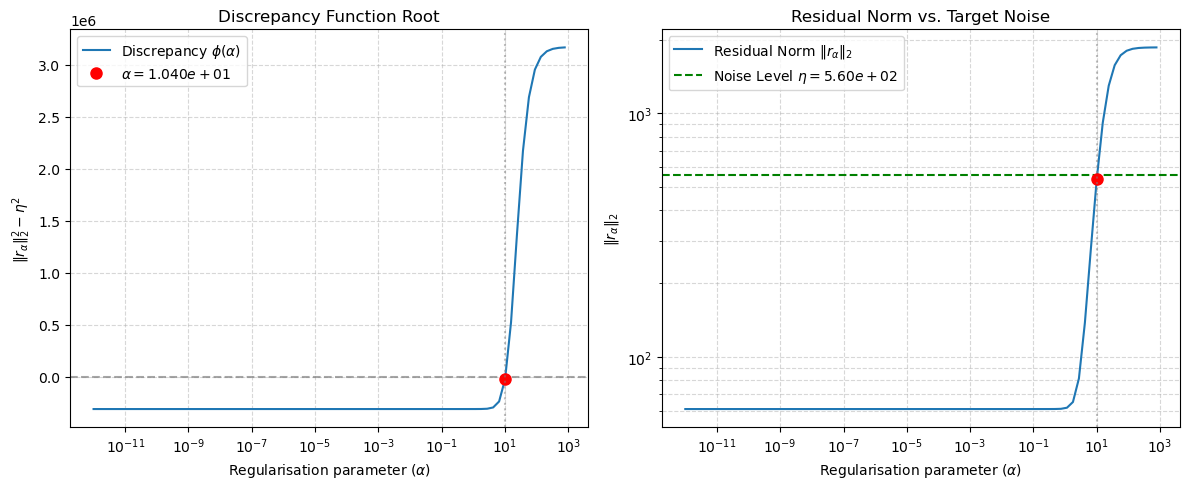

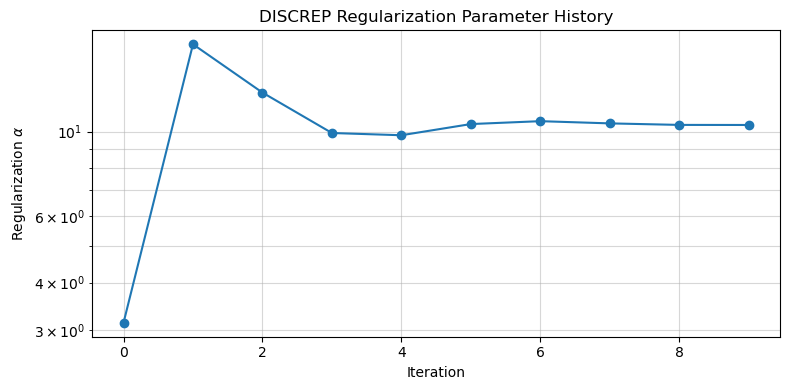

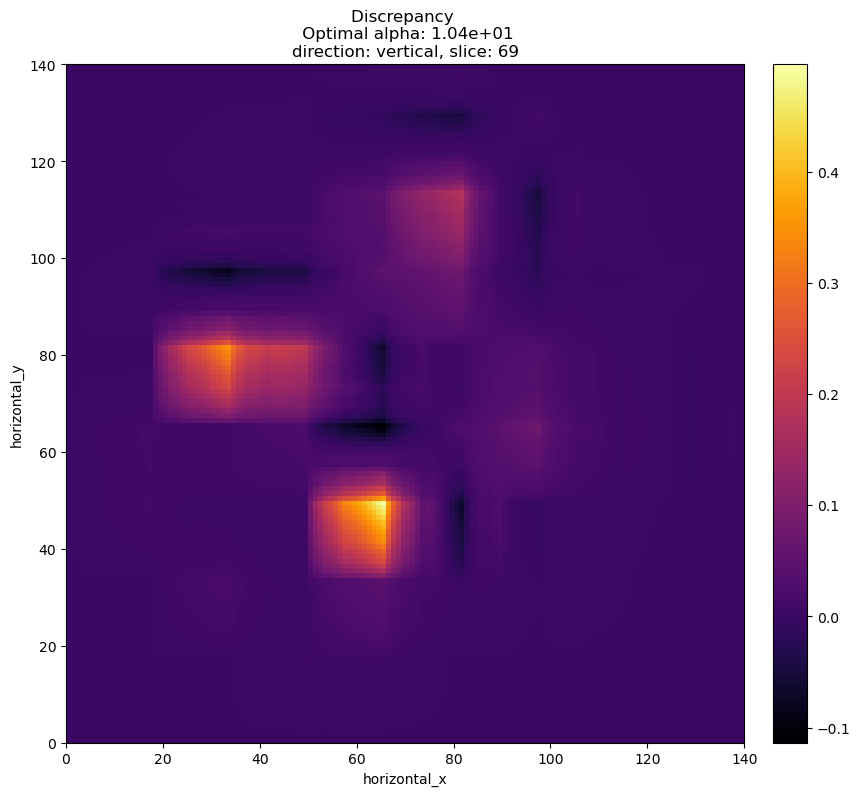

In [ ]:
print("The optimal parameter it finds is", hybridlsqrD.regalpha, "in", hybridlsqrD.iteration, "iterations")

hybridlsqrD.reg_rule.plot_function()
try:  
    hybridlsqrD.reg_rule.plot_history()
except:
    pass

show2D(hybridlsqrD.solution,
        title=f"Discrepancy \n Optimal alpha: {hybridlsqrD.regalpha:.2e}",
        slice_list=('vertical', max_vslice),
        fix_range=cbar,
        cmap="inferno")

## 2. Standard GCV Rule

In [29]:
gcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                adaptive_weight=False)

hybridlsqrgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                           struct_operator=W,
                           xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type=norm_type, hybrid_reg_rule=gcv_rule)
hybridlsqrgcv.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 4.35762984738217 in 0 iterations


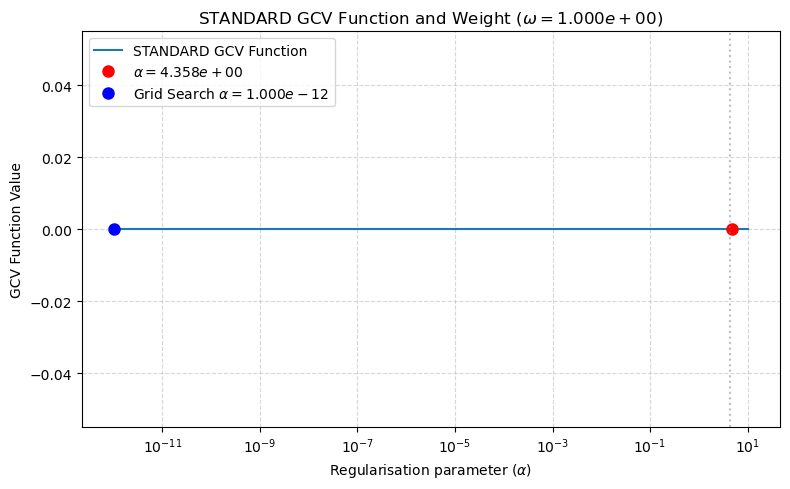

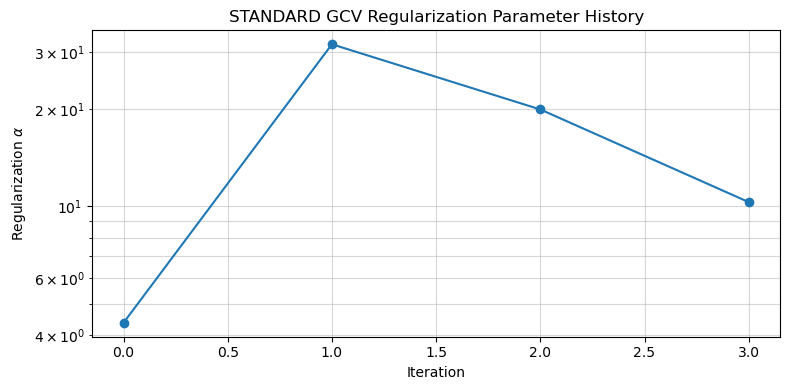

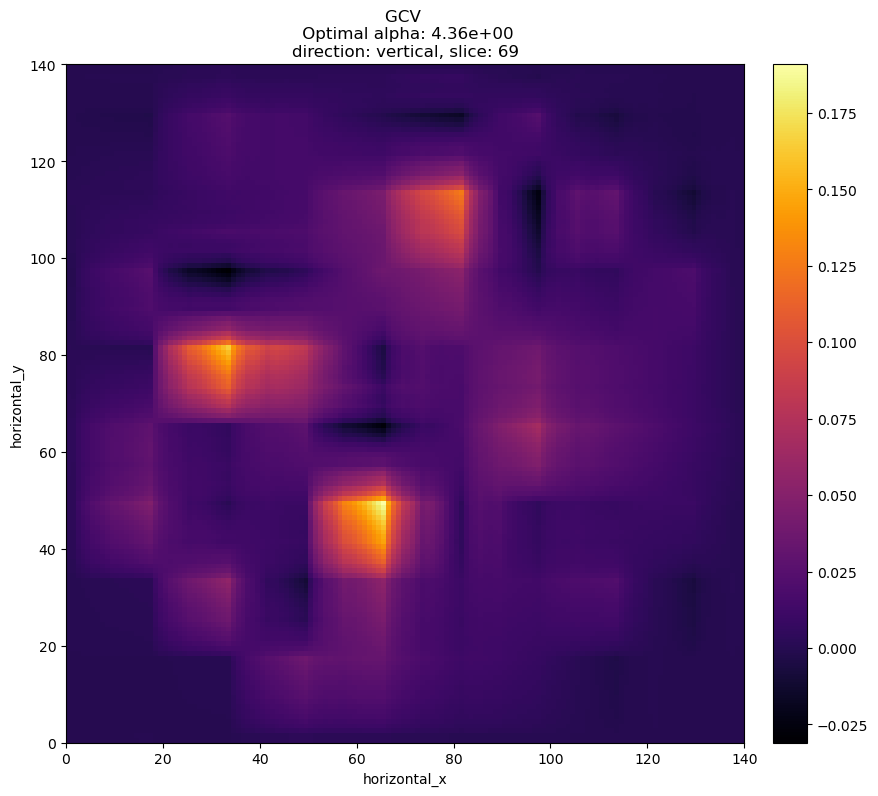

In [ ]:
print("The optimal parameter it finds is", hybridlsqrgcv.regalpha, "in", hybridlsqrgcv.iteration, "iterations")

hybridlsqrgcv.reg_rule.plot_function()
hybridlsqrgcv.reg_rule.plot_history()

show2D(hybridlsqrgcv.solution,
        title=f"GCV \n Optimal alpha: {hybridlsqrgcv.regalpha:.2e}",
        slice_list=('vertical', max_vslice),
        fix_range=cbar,
        cmap="inferno")

## 3. Weighted GCV Rule

In [31]:
wgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=False)

hybridlsqrwgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                            struct_operator=W,
                            xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type=norm_type, hybrid_reg_rule=wgcv_rule)
hybridlsqrwgcv.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 0.2520748112380581 in 6 iterations


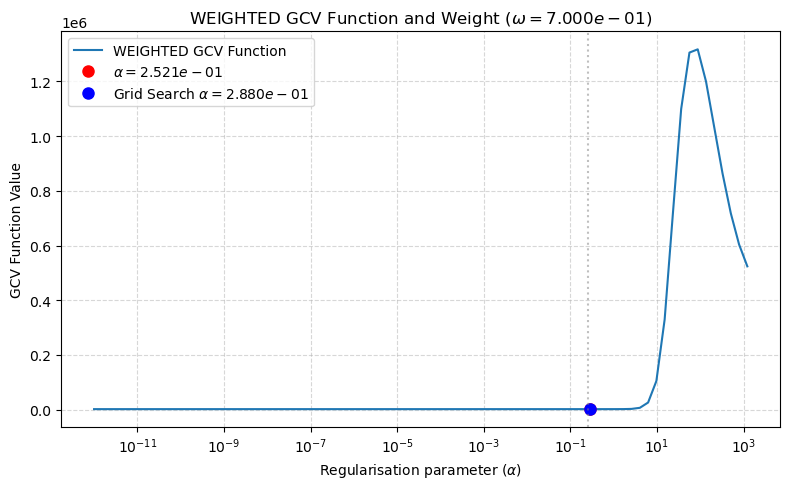

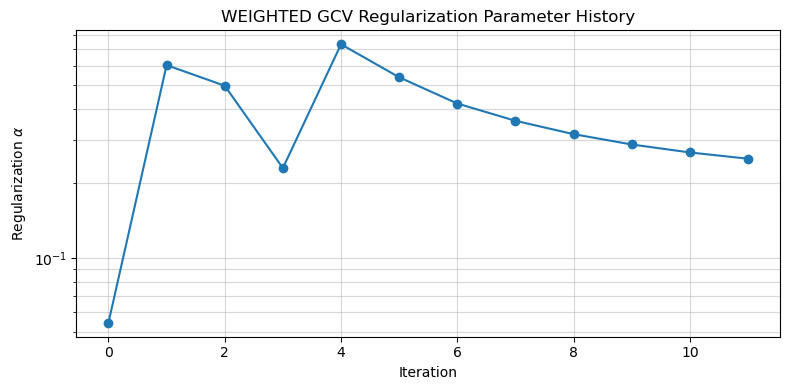

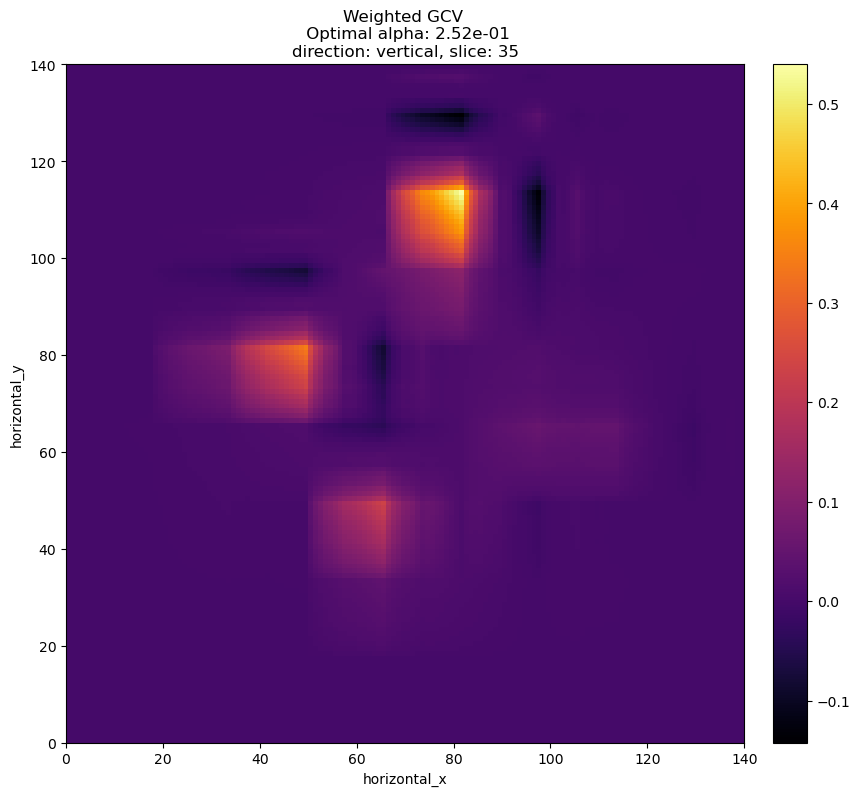

In [ ]:
print("The optimal parameter it finds is", hybridlsqrwgcv.regalpha, "in", hybridlsqrwgcv.iteration, "iterations")

hybridlsqrwgcv.reg_rule.plot_function()
hybridlsqrwgcv.reg_rule.plot_history()

show2D(hybridlsqrwgcv.solution,
        title=f"Weighted GCV \n Optimal alpha: {hybridlsqrwgcv.regalpha:.2e}",
        slice_list=('vertical', max_vslice),
        fix_range=cbar,
        cmap="inferno")

## 4. Adaptive-Weighted GCV Rule

In [33]:
awgcv_rule = UpdateRegGCV(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                gcv_weight=0.7,
                                adaptive_weight=True)

hybridlsqrawgcv = HybridGLSQR(operator=A, data=data, initial=initial,
                              struct_operator=W,
                            xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type=norm_type, hybrid_reg_rule=awgcv_rule)
hybridlsqrawgcv.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 0.03820581805360612 in 0 iterations


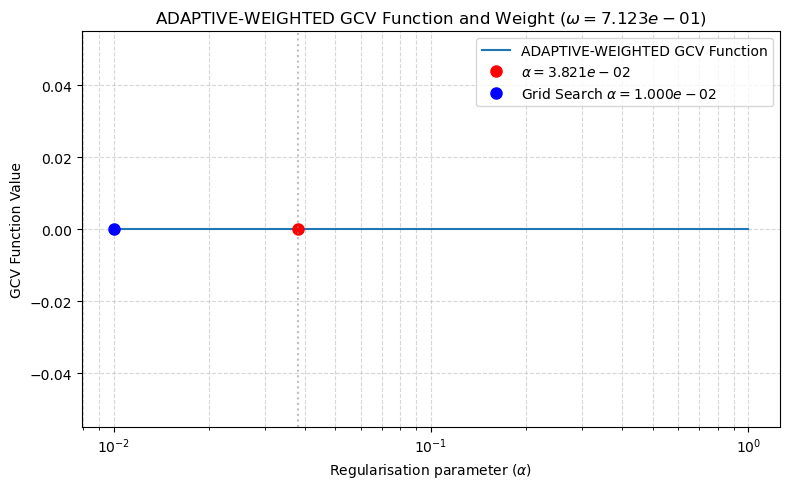

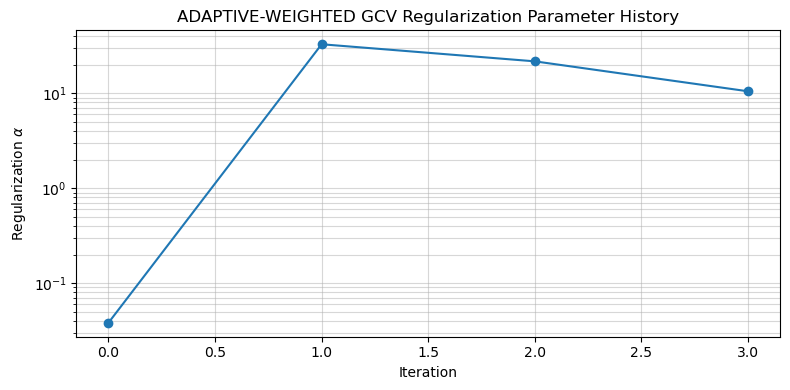

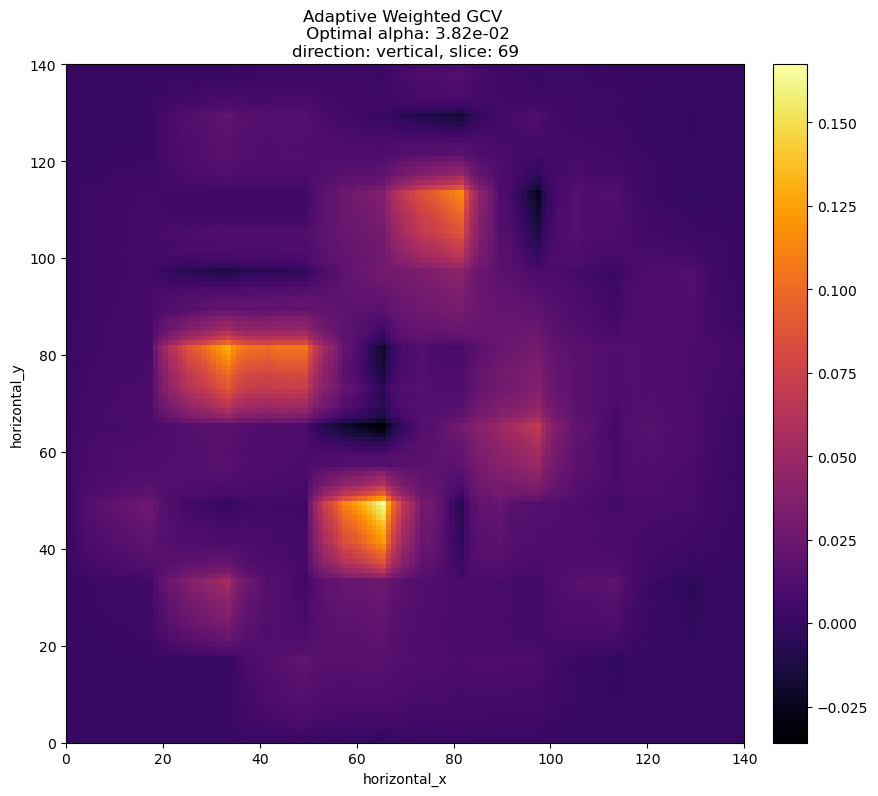

In [ ]:
print("The optimal parameter it finds is", hybridlsqrawgcv.regalpha, "in", hybridlsqrawgcv.iteration, "iterations")

hybridlsqrawgcv.reg_rule.plot_function(regalpha_limits=(1e-2, 1))
hybridlsqrawgcv.reg_rule.plot_history()

show2D(hybridlsqrawgcv.solution,
        title=f"Adaptive Weighted GCV \n Optimal alpha: {hybridlsqrawgcv.regalpha:.2e}",
        slice_list=('vertical', max_vslice),
        fix_range=cbar,
        cmap="inferno")

## 5. Reginska Rule

In [35]:
reginska_rule = UpdateRegReginska(data_size=data.size,
                                domain_size=initial.size, 
                                tol=1e-3,
                                mu=0.5)

hybridlsqrreginska = HybridGLSQR(operator=A, data=data, initial=initial,
                                 struct_operator=W,
                            xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type=norm_type, hybrid_reg_rule=reginska_rule)
hybridlsqrreginska.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 0.27014132451204753 in 6 iterations


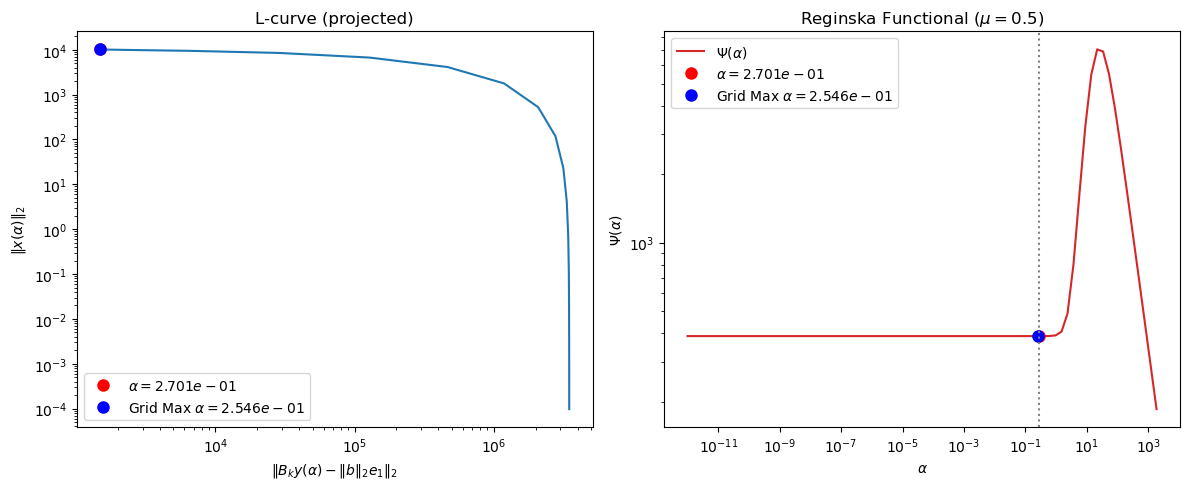

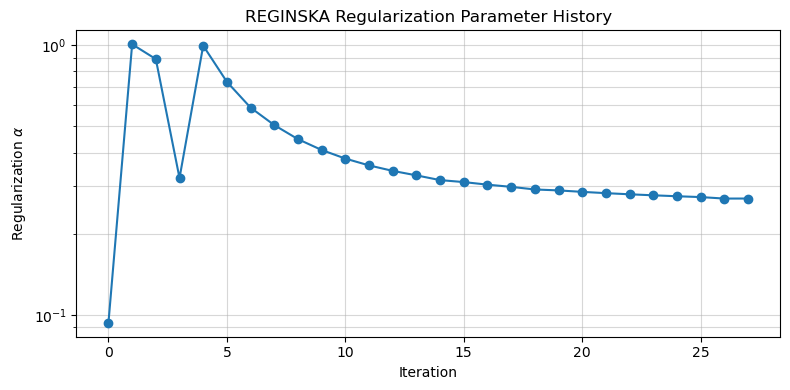

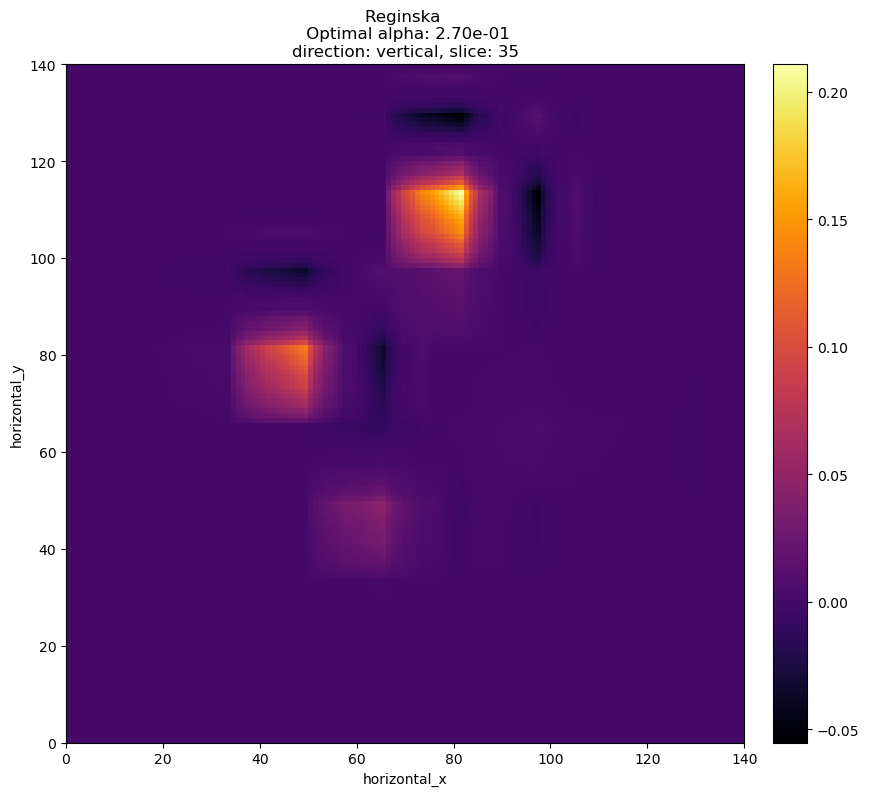

In [ ]:
print("The optimal parameter it finds is", hybridlsqrreginska.regalpha, "in", hybridlsqrreginska.iteration, "iterations")

hybridlsqrreginska.reg_rule.plot_function()
hybridlsqrreginska.reg_rule.plot_history()

show2D(hybridlsqrreginska.solution,
        title=f"Reginska \n Optimal alpha: {hybridlsqrreginska.regalpha:.2e}",
        slice_list=('vertical', max_vslice),
        fix_range=cbar,
        cmap="inferno")

## 5. UPRE Rule

In [37]:
upre_rule = UpdateRegUPRE(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol,
                                noise_variance=noisevariance)

hybridlsqrupre = HybridGLSQR(operator=A, data=data, initial=initial,
                             struct_operator=W,
                            xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type=norm_type, hybrid_reg_rule=upre_rule)
hybridlsqrupre.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 1e-12 in 7 iterations


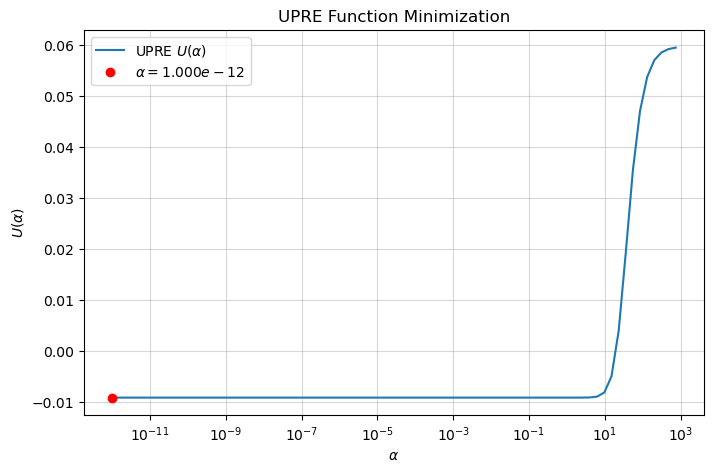

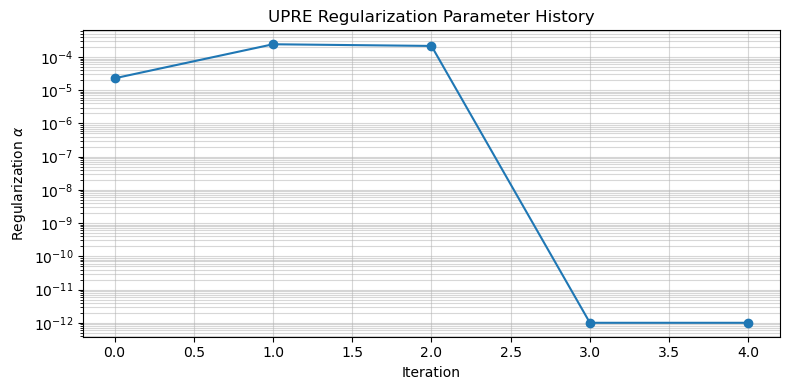

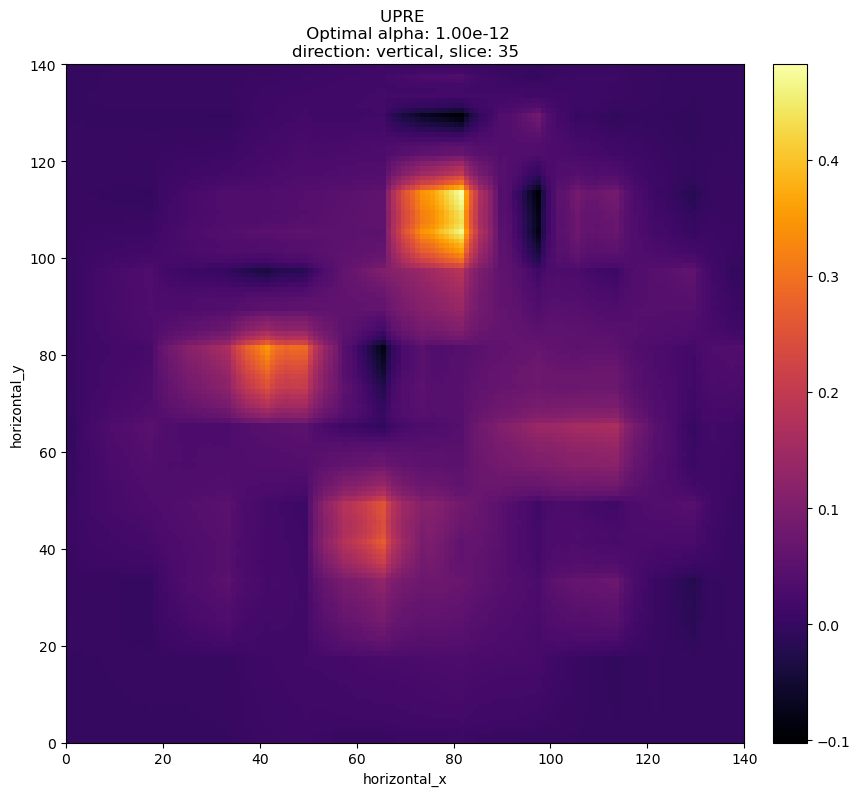

In [ ]:
print("The optimal parameter it finds is", hybridlsqrupre.regalpha, "in", hybridlsqrupre.iteration, "iterations")

hybridlsqrupre.reg_rule.plot_function()
try:
    hybridlsqrupre.reg_rule.plot_history()
except:
    pass

show2D(hybridlsqrupre.solution,
        title=f"UPRE \n Optimal alpha: {hybridlsqrupre.regalpha:.2e}",
        slice_list=('vertical', max_vslice),
        fix_range=cbar,
        cmap="inferno")

## 7. L-curve Rule

In [39]:
lcurve_rule = UpdateRegLcurve(data_size=data.size,
                                domain_size=initial.size, 
                                tol=alpha_tol)

hybridlsqrlcurve = HybridGLSQR(operator=A, data=data, initial=initial,
                           struct_operator=W,
                            xtol=xtol, reinitialize_GKB=reinitialize_GKB,
                         reg_norm_type=norm_type, hybrid_reg_rule=lcurve_rule)
hybridlsqrlcurve.run(maxit, verbose=True)

  0%|          | 0/50 [00:00<?, ?it/s]

The optimal parameter it finds is 1.4360025133861606e-06 in 50 iterations


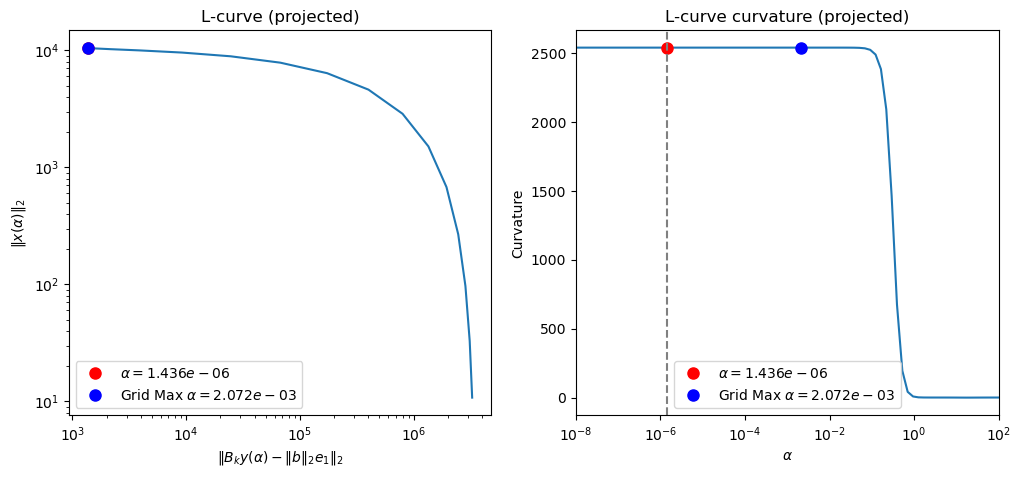

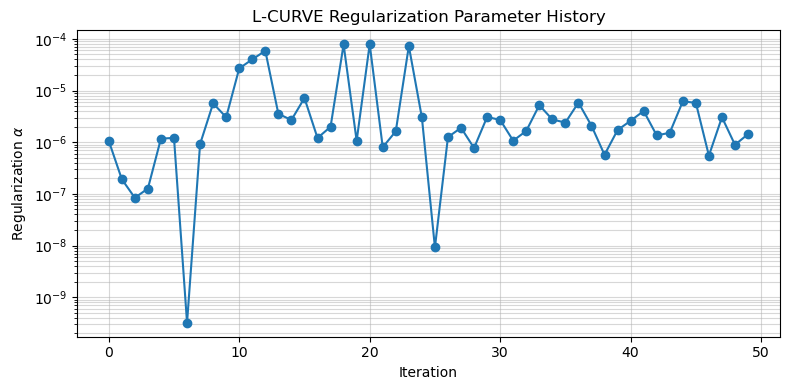

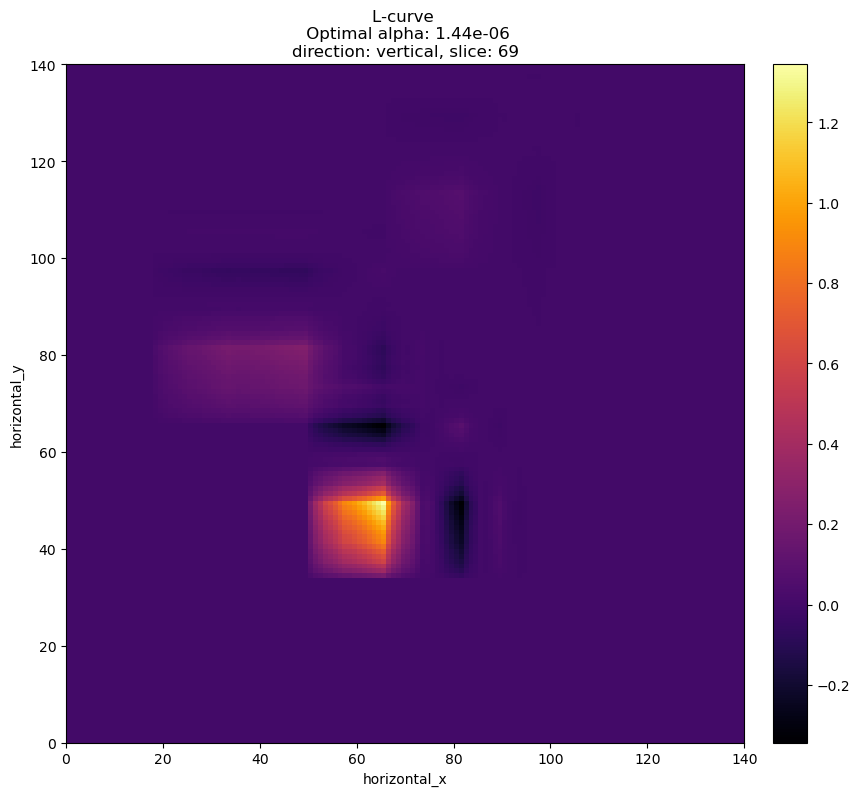

In [ ]:
print("The optimal parameter it finds is", hybridlsqrlcurve.regalpha, "in", hybridlsqrlcurve.iteration, "iterations")

hybridlsqrlcurve.reg_rule.plot_function(regalpha_limits=(1e-8, 1e2))
hybridlsqrlcurve.reg_rule.plot_history()

show2D(hybridlsqrlcurve.solution,
        title=f"L-curve \n Optimal alpha: {hybridlsqrlcurve.regalpha:.2e}",
        slice_list=('vertical', max_vslice),
        fix_range=cbar,
        cmap="inferno")

## Display Results
The results are shown in the figure below. 

In [ ]:
from ipywidgets import interact, IntSlider, Dropdown
import matplotlib.pyplot as plt
# Define the list of solutions and titles once
solutions = [hybridlsqrD.solution, hybridlsqrgcv.solution, hybridlsqrwgcv.solution, hybridlsqrawgcv.solution,
             hybridlsqrlcurve.solution, hybridlsqrreginska.solution, hybridlsqrupre.solution]

titles = [
    f'Discrep alpha = {hybridlsqrD.regalpha:.2e}',
    f'GCV alpha = {hybridlsqrgcv.regalpha:.2e}', 
    f'WGCV alpha = {hybridlsqrwgcv.regalpha:.2e}', 
    f'AWGCV alpha = {hybridlsqrawgcv.regalpha:.2e}',
    f'LCURVE alpha = {hybridlsqrlcurve.regalpha:.2e}',
    f'REGINSKA alpha = {hybridlsqrreginska.regalpha:.2e}',
    f'UPRE alpha = {hybridlsqrupre.regalpha:.2e}'
]

# Mapping for the dropdown
rule_options = {
    'All Rules': None,
    'Discrepancy': 0,
    'GCV': 1,
    'WGCV': 2,
    'AWGCV': 3,
    'L-Curve': 4,
    'Reginska': 5,
    'UPRE': 6
}

def update_display(vslice, rule_name,norm_name='L2'):
    # Determine which solutions to show
    idx = rule_options[rule_name]
    
    if idx is None:
        # Show all
        current_solutions = solutions
        current_titles = titles
        cols = 4
    else:
        # Show only the selected one
        current_solutions = [solutions[idx]]
        current_titles = [titles[idx]]
        cols = 1

    # Render using show2D
    fig = show2D(
        current_solutions,
        cmap='inferno', 
        slice_list=('vertical', vslice), 
        num_cols=cols,
        fix_range=cbar,
        title=current_titles
    )
    
    # Add the overall title (suptitle)
    # We use plt.gcf() to ensure we grab the figure show2D just created
    fig = plt.gcf()
    fig.suptitle(f"Hybrid GLSQR Analysis {norm_name}\nRule: {rule_name} | Vertical Slice: {vslice}", 
                 fontsize=14, fontweight='bold', y=1.05)
    
    # Adjust layout so the suptitle doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Determine dimensions
max_vslice = solutions[0].shape[0] - 1

# Create the interactive dashboard
interact(
    update_display, 
    vslice=IntSlider(min=0, max=max_vslice, step=1, value=200, description='Slice:'),
    rule_name=Dropdown(options=list(rule_options.keys()), value='Reginska', description='Rule:')
);

interactive(children=(IntSlider(value=69, description='Slice:', max=69), Dropdown(description='Rule:', index=6…